## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df.group == 'treatment') == (df.landing_page == 'new_page')) == False].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df.group == 'treatment') == (df.landing_page == 'new_page')) == True].reset_index()

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2.group == 'treatment') == (df2.landing_page == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below for cleaning data.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         290585 non-null  int64 
 1   user_id       290585 non-null  int64 
 2   timestamp     290585 non-null  object
 3   group         290585 non-null  object
 4   landing_page  290585 non-null  object
 5   converted     290585 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.3+ MB


b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.drop('index', axis = 1, inplace = True)

In [13]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
# user_id = 773192

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop(2862, axis = 0, inplace = True)

In [16]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below for basic probability test.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2.query('landing_page == "new_page"').user_id.count()/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

It was found that almost 50% of the population received new_page and hence belonged to the treatment group, & therefore, the other 50% received old_page, belonging to the control group, which makes it easier to compare the other probabilities.

So, with that sorted, it was found that the probability of an individual belonging to the control group is 12% & that of treatment group is 11.8%.

This tells that the new treatment page doesn't appear to lead to more conversions than the old page.
So for now, there appears to be no evidence, that the new page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$: $p_{new}$ ≤ $p_{old}$ 

$H_{1}$: $p_{new}$ > $p_{old}$ 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null?

In [22]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = df2.query('landing_page == "new_page"').user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1 - p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1 - p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.0003009123037634315

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
# Using Binomial funtion for simulation.
new_converted_10000 = np.random.binomial(n_new, p_new, 10000) / n_new
old_converted_10000 = np.random.binomial(n_old, p_old, 10000) / n_old

p_diffs = new_converted_10000 - old_converted_10000
p_diffs

array([-0.00084168, -0.00035982, -0.00212881, ...,  0.00099585,
        0.00080309, -0.00035322])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

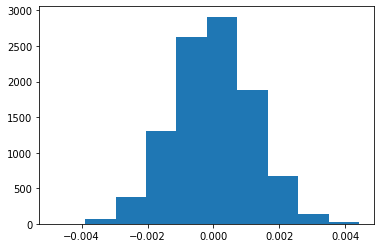

In [29]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
obs_diff

-0.0015782389853555567

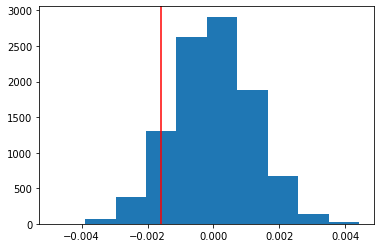

In [31]:
plt.hist(p_diffs);
plt.axvline(obs_diff, color='r');

In [32]:
p_val = (p_diffs > obs_diff).mean()
p_val

0.9052

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The observed difference in conversion rates according to the null hypothesis is -0.0015. 

Now if we take this value and plot it on the histogram, we can see that it lies within the sampling distribution of our simulated values stored in p_diffs.

Using the same, we can manually calculate the p-value, which is basically the probablity of statistic if the null hypothesis is true.

In our case, the p-value was found to be 0.9052 which is greater than 0.05. In general, an alpha of 0.05 is used as the cutoff for significance in majority fields. This indicates that we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
#converted_old = len(df2[df2.landing_page == 'old_page'][df2.converted == 1])
converted_old = df2.query('landing_page == "old_page" and converted == 1').user_id.count()
converted_old

17489

In [34]:
import statsmodels.api as sm

converted_old = df2.query('landing_page == "old_page" and converted == 1').user_id.count()
converted_new = df2.query('landing_page == "new_page" and converted == 1').user_id.count()

n_old = df2.query('landing_page == "old_page"').user_id.count()
n_new = df2.query('landing_page == "new_page"').user_id.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [35]:
z_score, p_value = sm.stats.proportions_ztest([converted_new, converted_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score obtained here is -1.3109, this tell us that it's 1.3109 times standard deviation away from the mean. Which matches with our observation seen in the plots above.

Also, the p-value obtained through this method is 0.905, which is again, greater than 0.05.

Ultimately this proves that we fail to reject the null hypothesis.

This conclusion is similar to that of, in parts **j.** and **k.**

Hence the new page is no different, nor better than the old page, statistically.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression will be better because it predicts a probability between 0 & 1.

In our case it will do the same for converted.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group']).treatment

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [38]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        00:08:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value associated with ab_page is 0.190. 

In Part II, the null hypothesis was that the old page was more or equally effective at converting users, than the new page.
Which makes the alternate hypothesis to be, that the old page was less effective at converting users, than the new page.

Whereas, in part III, while fitting the logistic regression model, the assumed null hypothesis was that the old page has the same effectiveness as the new page.
Which inturn makes the alternate hypothesis to be, that the new page is not equal in effectiveness as the old page in converting users.

This also tells us that the regression model is set up as two-tailed test where as in Part II it was a one tailed test (according to the null & alternate hypothesis).

And since, the p-value (from Part III) is more than 0.05 , this means that we reject the null hypothesis that both pages have equal effectiveness at converting users.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It indeed is a good idea to consider other factors to add into the regression model as it can tell us which factors are essentially important at the first place to predict whether an individual converts or not, and that gives us an advantage on only reading those esential factors rather than all.

But, the disadvantage of choosing other factors could also affect the model prediction due to these following reasons.
<ul>
<li>Non-linearity of the response-predictor relationships</li>
<li>Correlation of error terms</li>
<li>Non-constant Variance and Normally Distributed Errors</li>
<li>Outliers / High leverage points</li>
<li>Multicollinearity</li>
</ul>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries = pd.read_csv('countries.csv')
df_new = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
df_new = df_new.join(pd.get_dummies(df_new['country'])[['CA', 'UK']])

In [42]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [43]:
log_mod_new = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results_new = log_mod_new.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [44]:
results_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        00:08:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [45]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('converted ~ ab_page + CA + UK', df_new, return_type = 'dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

In [46]:
vif

,VIF Factor,features
0,2.428940,Intercept
1,1.000006,ab_page
2,1.017759,CA
3,1.017761,UK


The p-values for all countries & page are above 0.05 which signifies that they are statistically insignificant in predicting the conversion of users.

The vif values are all less than 10.0 which suggest less problem of multicollinearity. Therefore maybe other factors are affecting the insignificance of country & page for our regression model.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
df_new['CA_ab_page'] = df_new['CA']*df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']

In [48]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,CA_ab_page,UK_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [49]:
log_mod_inter = sm.Logit(df_new['converted'], df_new[['intercept','CA', 'UK', 'CA_ab_page', 'UK_ab_page']])
results_inter = log_mod_inter.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [50]:
results_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Wed, 29 Apr 2020   Pseudo R-squ.:               2.417e-05
Time:                        00:08:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK             0.0045      0.018      0.257      0.797      -0.030       0.039
CA_ab_page    -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_ab_page     0.0108      0.023      0.475      0.635      -0.034       0.056
==============================================================================
"""

In [51]:
y_new, X_new = dmatrices('converted ~ CA + UK + CA_ab_page + UK_ab_page', df_new, return_type = 'dataframe')
vif_new = pd.DataFrame()
vif_new['VIF Factor'] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif_new['features'] = X_new.columns

In [52]:
vif_new

,VIF Factor,features
0,1.427097,Intercept
1,1.981457,CA
2,1.763133,UK
3,1.963699,CA_ab_page
4,1.745376,UK_ab_page


So, the p-values for all countries & page and as well as the interactions between them are above 0.05 which signifies that they are statistically insignificant in predicting the conversion of users.

Also, the vif values are all less than 10.0 which suggest less problem of multicollinearity. Therefore maybe other factors are affecting the insignificance for the interaction column of UK country & ab_page for our regression model.

<a id='conclusion'></a>
## Conclusion

This project aimed to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

In Part I, we saw the probability of conversion rates and saw that the old page was performing better than the new page.

In Part II, we assumed the old page was more or equally effective at converting users than the new page (null hypothesis). We calculated the p-value of 0.905, and hence we failed to reject the null hypothesis. We also calculated the z-value which also failed to reject the null hypothesis.

In Part III, we used the logistic regression model to calculate the p-value. The results also could not reject the null hypothesis.

We also made us of another factor into the regression model, which is the country in which a user lives. But got to know that the user's country of residence was insignificant to conversion rates. And the same was also proven when we created a new regression model with page and country of residence.

We can therefore, conclude that there is no practical reason to launch the new page.